## Homework 2

### Gregory Polyakov M05-115a

This project explores the graph-based recommendation algorithm from the paper [Graph Convolutional Matrix Completion](https://arxiv.org/pdf/1706.02263v2.pdf).

#### Brief Algorithm Description

A sparse matrix of user-item ratings of size $(N_u, N_v)$ is given, where $N_u$ represents the number of users and $N_v$ represents the number of items. Observed ratings range from {1, ..., r}, while unobserved ones are marked as zero. The goal is to predict the unobserved ratings based on the observed values.

To achieve this, the data is represented as a graph $(\mathcal{W}, \mathcal{E}, \mathcal{R})$ with nodes representing users $\mathcal{U}$ and items $\mathcal{V}$. $\mathcal{U} \cup \mathcal{V} = \mathcal{W}$. Each edge is represented as $(u_i, r, v_i)$, where $r \in \mathcal{R}$ denotes the rating.

The model is a graph autoencoder consisting of:
1. Encoder $Y = f(X, A)$, which takes the embeddings of all graph nodes $X = N \times D$, the adjacency matrix $A$, and outputs embeddings $Y = N \times E$.
2. Decoder $\hat{A} = g(Y)$, which uses the encoder embeddings to predict values in the adjacency matrix.

In the paper, the adjacency matrix $A$, containing discrete ratings as weights, is represented as a one-hot matrix $A = [M_1, ..., M_r]$, where each binary matrix $M_i$ corresponds to a specific rating.

The encoder is a graph convolutional network that aggregates embeddings of neighbors at each node with certain coefficients:

$$\mu_{j \rightarrow i, r} = \frac{1}{c_{i, j}} W_r x_{j}$$

Here, $x_{j}$ represents the embedding of neighbor $j$. For each rating value, there is a corresponding weight matrix $W_r$ for convolution. $c_{i, j} = \sqrt{N_i N_j}$ is a symmetric normalization coefficient based on the number of node neighbors.

Based on my experiments, normalization is only done with respect to $\sqrt{N_j}$.

Then, the embeddings obtained after convolutions are summed for each node and a non-linearity is applied:

$$h_i = \sigma \left( \text{sum}(\sum_{j \in N_{i, 1}} \mu_{j \rightarrow i, 1}, ...,  \sum_{j \in N_{i, r}} \mu_{j \rightarrow i, r})\right)$$

Afterwards, but still within the encoder stage, the authors suggest applying a simple linear layer with non-linearity for each node. The weights can differ for item and user nodes:

$$u_i = \sigma(W h_i)$$

As for the decoder, the authors consider a bilinear transformation with weight matrices $Q_r$. The probabilities of each rating are calculated as:

$$p\left(M_{ij} = r\right) = \frac{e^{u_i^T Q_r v_j}}{\sum_{s \in R} e^{u_i^T Q_s v_j}}$$

#### Load Data

To begin, we'll attempt to reproduce the paper's results using the [MovieLens 100K dataset](https://grouplens.org/datasets/movielens/100k/).

#### Download Dataset

In [38]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from random import sample
import matplotlib.pyplot as plt
from IPython import display

import torch
import numpy as np

from scipy.sparse import csr_matrix
import h5py

url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'
request = urlopen(url)

with ZipFile(BytesIO(request.read())) as zip_ref:
    zip_ref.extractall('./')

#### Let's build the adjacency matrix of the graph from the data

The ratings given by users to movies are in the file `u.data`.

In [39]:
data = pd.read_csv('./ml-100k/u.data', sep='\t', 
                   header=None, 
                   names=['user', 'item', 'rating', 'timestamp'], 
                   encoding = 'latin-1')
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


The information about users is contained in files `u.item` and `u.user`

In [40]:
movie_data = pd.read_csv('./ml-100k/u.item', sep=r'|', header=None, encoding = 'latin-1')
user_data = pd.read_csv('./ml-100k/u.user', sep=r'|', header=None, encoding = 'latin-1')
num_users = user_data.shape[0]
num_items = movie_data.shape[0]

print(f'Number of users: {num_users}')
print(f'Number of films: {num_items}')

Number of users: 943
Number of films: 1682


In [52]:
movie_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [53]:
user_data.head(5)

,0,1,2,3,4
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [54]:
movie_name_list = movie_data[1].values

The current dataframe contains edge list of the considering graph
Let's split it into train and validation sets.

In [41]:
train, val = train_test_split(data[['user', 'item', 'rating']].values, test_size=0.2, random_state=42)
all_edges =  torch.tensor(data[['user', 'item', 'rating']].values, dtype=torch.long)
train = torch.tensor(train, dtype=torch.long)
val = torch.tensor(val, dtype=torch.long)
print(f'Number of edges in train: {train.shape[0]}')
print(f'Number of edges in val: {val.shape[0]}')

Number of edges in train: 80000
Number of edges in val: 20000


Let's create 5 adjacency matrices from the list of edges, where in the $i$-th matrix, element $(j, k)$ will be equal to 1 if user $j$ rated movie $k$ with rating $i$.


In [42]:
def make_adj_matrix(num_users, num_items, edges_list, num_classes=5):
    adj_matrix = torch.zeros(num_users, num_items, dtype=torch.long)
    adj_matrix[edges_list[:, 0]-1, edges_list[:, 1]-1] = edges_list[:, 2]
    
    adj_matrices_class = []
    for cl in range(1, num_classes+1):
        adj_matrix_class = torch.zeros(num_users, num_items)
        adj_matrix_class[adj_matrix == cl] = 1
        adj_matrices_class.append(adj_matrix_class)
    return torch.stack(adj_matrices_class, 0)

In [43]:
whole_adj_matr = make_adj_matrix(num_users, num_items, all_edges)
train_adj_matr = make_adj_matrix(num_users, num_items, train)
val_adj_matr = make_adj_matrix(num_users, num_items, val)

In [125]:
train_adj_matr[0].sum(0).shape

torch.Size([1682])

#### Implementation of the main algorithm

In [179]:
class MessagePassing(torch.nn.Module):
    def __init__(self, num_classes, embedding_dim, hidden_dim):
        super(MessagePassing, self).__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        
        # apply a linear layer for each type of rating before message passing (W_r)
        self.rating_linear = torch.nn.Parameter(torch.Tensor(num_classes, embedding_dim, embedding_dim))
        self.playlist_song_linear = torch.nn.Parameter(torch.Tensor(2, embedding_dim, hidden_dim))
        torch.nn.init.normal_(self.rating_linear, std=0.1)
        torch.nn.init.normal_(self.playlist_song_linear, std=0.1)
        
        self.relu = torch.nn.ReLU()
    
    def normalize(self, adj_matrix):
        # apply symmetric normalization depending on the number of neighbors before message passing
        # based on the implementation of graph convolutional networks
        song_coeff = 1 / (adj_matrix.sum(dim=0) ** 0.5)
        song_coeff[torch.isinf(song_coeff)] = 0.
        song_coeff = song_coeff.reshape((1, -1)).expand(adj_matrix.shape[0], -1)
        playlist_coeff = 1 / (adj_matrix.sum(dim=1) ** 0.5)
        playlist_coeff[torch.isinf(playlist_coeff)] = 0.
        playlist_coeff = playlist_coeff.reshape((-1, 1)).expand(-1, adj_matrix.shape[1])
        
        return adj_matrix * song_coeff
    
    def forward(self, playlist_embeddings, song_embeddings, playlists, songs, adj_matrices):
        assert self.num_classes == adj_matrices.shape[0]
        
        all_playlist_embeddings = []
        all_song_embeddings = []
        for i in range(adj_matrices.shape[0]):
            # perform message passing for each type of rating
            adj_matrix = adj_matrices[i]
            norm = self.normalize(adj_matrix)
            playlist_norms = norm[playlists]
            song_norms = norm.T[songs]
            
            # transform each node's embedding and add with normalized weights
            new_playlist_embeddings = playlist_norms @ (song_embeddings @ self.rating_linear[i])
            new_song_embeddings = song_norms @ (playlist_embeddings @ self.rating_linear[i])
            
            all_playlist_embeddings.append(new_playlist_embeddings)
            all_song_embeddings.append(new_song_embeddings)
        
        # sum the embeddings for all classes
        all_playlist_embeddings = torch.stack(all_playlist_embeddings, 0).sum(0)
        all_song_embeddings = torch.stack(all_song_embeddings, 0).sum(0)
        
        # linear transformation of user and item embeddings respectively
        all_playlist_embeddings = self.relu(all_playlist_embeddings @ self.playlist_song_linear[0])
        all_song_embeddings = self.relu(all_song_embeddings @ self.playlist_song_linear[0])

        return all_playlist_embeddings, all_song_embeddings


class Decoder(torch.nn.Module):
    def __init__(self, num_classes, embedding_dim):
        super(Decoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # bilinear transformation of user and item embeddings based on class
        self.bilinear_operator = torch.nn.Parameter(torch.Tensor(self.num_classes,
                                                                 self.embedding_dim,
                                                                 self.embedding_dim))
        torch.nn.init.normal_(self.bilinear_operator, std=0.1)
        
    def forward(self, playlist_features, song_features):
        output = []
        for i in range(self.num_classes):
            output.append(playlist_features @ self.bilinear_operator[i] @ song_features.T)
        return torch.stack(output, 0)

    
class GAE(torch.nn.Module):
    def __init__(self, num_playlists, num_songs, num_classes,
                 embedding_dim, hidden_dim, dropout=0.7):
        super(GAE, self).__init__()
        self.num_playlists = num_playlists
        self.num_songs = num_songs
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        
        # initial approximation of user and item node embeddings
        self.playlist_embeddings = torch.nn.Parameter(torch.Tensor(self.num_playlists, self.embedding_dim))
        self.song_embeddings = torch.nn.Parameter(torch.Tensor(self.num_songs, self.embedding_dim))
        torch.nn.init.normal_(self.playlist_embeddings, std=0.1)
        torch.nn.init.normal_(self.song_embeddings, std=0.1)
        
        # encoder and decoder
        self.graph_conv = MessagePassing(num_classes, embedding_dim, hidden_dim)
        self.decoder = Decoder(num_classes, hidden_dim)
        self.softmax =  torch.nn.Softmax(dim=0)
    
    def forward(self, playlists, songs, adj_matrix):
        playlist_embeddings, song_embeddings = self.graph_conv(self.playlist_embeddings, self.song_embeddings,
                                                               playlists, songs, adj_matrix)
        scores = self.decoder(playlist_embeddings, song_embeddings)
        scores = self.softmax(scores)
        return scores, self.ratings_from_scores(scores)
    
    def ratings_from_scores(self, scores):
        ratings = torch.stack([(r+1)*rating_score 
                               for r, rating_score in enumerate(scores)], 0)
        ratings = torch.sum(ratings, 0)
        return ratings
    
    def predict(self, playlist, adj_matrix):
        _, ratings = self.forward([playlist], range(self.num_songs), adj_matrix)
        return ratings

#### Loss, metrics, training pipeline

In [236]:
def rmse(preds, target):
    labels = torch.max(target, 0)[1].float() + 1.
    
    valid_edges = target.sum(dim=0)
    nonzero = torch.nonzero(valid_edges)
    
    mse = (valid_edges * (labels - preds)**2).sum() / len(nonzero)
    rmse = torch.sqrt(mse)
    return rmse


def loss(probs, target):
    probs = probs.reshape(probs.shape[0], -1).T
    target = target.reshape(target.shape[0], -1).T

    valid_edges = target.sum(dim=1)
    nonzero = len(torch.nonzero(valid_edges))
    target = target.max(dim=1)[1]

    loss = torch.nn.functional.cross_entropy(input=probs, target=target,
                                             reduction='none')
    loss = torch.sum(torch.mul(valid_edges, loss)) / nonzero
    return loss


def train(model, adj_matrix, num_playlists, num_songs, optim):
    model.train()
    optim.zero_grad()
    probs, predictions = model(torch.tensor(range(num_playlists)),
                               torch.tensor(range(num_songs)),
                               adj_matrix.clone())
    
    curr_loss = loss(probs, adj_matrix.detach())
    curr_rmse = rmse(predictions, adj_matrix)
    curr_loss.backward()
    optim.step()
    return curr_loss, curr_rmse

def evaluate(model, adj_matrix, num_playlists, num_songs):
    model.eval()
    u = torch.tensor(range(num_playlists))
    v = torch.tensor(range(num_songs))
    
    probs, predictions = model(u, v, adj_matrix.clone())
    return loss(probs, adj_matrix), rmse(predictions, adj_matrix)

In [237]:
def plot(train_losses, val_losses, train_rmses, val_rmses):
    plt.figure(figsize=(8, 3))
    plt.subplot(121)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.legend()
    plt.title('Loss')
    plt.subplot(122)
    plt.plot(train_rmses, label='train')
    plt.plot(val_rmses, label='val')
    plt.legend()
    plt.title('RMSE')
    plt.show()

def train_loop(num_users, num_items, train_adj_matr, val_adj_matr, num_epochs=100):
    model = GAE(num_users, num_items, train_adj_matr.shape[0], 10, 10)
    optim = torch.optim.Adam(model.parameters(), lr=1e-2)

    train_losses = []
    train_rmses = []
    val_losses = []
    val_rmses = []
    for epoch in tqdm(range(num_epochs)):
        train_loss, train_rmse = train(model, train_adj_matr,
                                       num_users, num_items, optim)
        val_loss, val_rmse = evaluate(model, val_adj_matr, num_users, num_items)
        train_losses.append(train_loss.detach().numpy())
        val_losses.append(val_loss.detach().numpy())
        train_rmses.append(train_rmse.detach().numpy())
        val_rmses.append(val_rmse.detach().numpy())
        
        if epoch > 0 and epoch % 10 == 0:
            plot(train_losses, val_losses, train_rmses, val_rmses)
            
            display.clear_output(wait=True)
    return train_losses, val_losses, train_rmses, val_rmses, model

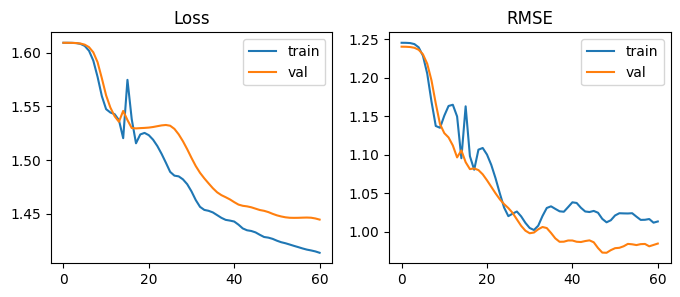

In [175]:
train_losses, val_losses, train_rmses, val_rmses, model = train_loop(num_users, num_items,
                                                              train_adj_matr, val_adj_matr,
                                                              num_epochs=61)
plot(train_losses, val_losses, train_rmses, val_rmses)

In [176]:
print(f'Best val RMSE: {min(val_rmses)}')

Best val RMSE: 0.9726685285568237


Achieved an RMSE of ~0.973 without using additional features and dropout, as used in the paper. This already outperforms some of the baselines compared in the paper.
Paper's Result: RMSE ~0.91

#### Let's attempt to recommend movies to users.

To do this, we'll take the adjacency matrix of the entire graph, feed it into GC-MC, and output the predicted scores for those values that were originally zeros in the matrix.

In [189]:
def get_top_films(model, user, adj_matr, film_list, top=10): 
    # obtain predictions
    recommendations = model.predict(user, adj_matr)
    # obtain ratings from the adjacency matrix
    known_ratings = model.ratings_from_scores(adj_matr)[user]
    
    # zero out scores of films that are already rated to recommend new ones
    recommendations[0, adj_matr[:, user, :].sum(0).bool()] = 0
    
    top_rec = recommendations[0].argsort(descending=True).detach().cpu().numpy()
    top_ratings = known_ratings.argsort(descending=True).detach().cpu().numpy()
    
    res = pd.DataFrame({'top_ratings': film_list[top_ratings].tolist(),
                        'top_recommendations': film_list[top_rec].tolist()})
    return res

In [192]:
res = get_top_films(model, 3, whole_adj_matr, movie_name_list)
res.head(10)

,top_ratings,top_recommendations
0,Lost Highway (1997),"Empire Strikes Back, The (1980)"
1,Star Wars (1977),Fargo (1996)
2,Liar Liar (1997),"Silence of the Lambs, The (1991)"
3,Blues Brothers 2000 (1998),Return of the Jedi (1983)
4,Incognito (1997),Titanic (1997)
5,Contact (1997),"Godfather, The (1972)"
6,Wonderland (1997),Raiders of the Lost Ark (1981)
7,"Assignment, The (1997)","English Patient, The (1996)"
8,"Wedding Singer, The (1998)","Full Monty, The (1997)"
9,Air Force One (1997),Good Will Hunting (1997)


We can see that, firstly, among the recommendations, there are many popular movies. Secondly, for instance, we can notice that the user liked Star Wars, and the model recommended two more Star Wars movies.

#### Let's now experiment with a music recommendation.

In [193]:
# from https://github.com/fmonti/mgcnn
def load_matlab_file(path_file, name_field):
    """
    load '.mat' files
    inputs:
        path_file, string containing the file path
        name_field, string containig the field name (default='shape')
    warning:
        '.mat' files should be saved in the '-v7.3' format
    """
    db = h5py.File(path_file, 'r')
    ds = db[name_field]
    print(ds)
    try:
        if 'ir' in ds.keys():
            data = np.asarray(ds['data'])
            ir   = np.asarray(ds['ir'])
            jc   = np.asarray(ds['jc'])
            out  = sp.csc_matrix((data, ir, jc)).astype(np.float32)
    except AttributeError:
        # Transpose in case is a dense matrix because of the row- vs column- major ordering between python and matlab
        out = np.asarray(ds).astype(np.float32).T

    db.close()

    return out

Loading the data commonly used in the literature. They are already divided into train and test sets.

In [201]:
path_dataset = './yahoo_music/training_test_dataset_10_NNs.mat'
# ratings
all_ratings = load_matlab_file(path_dataset, 'M')
# edges for train
train_edges = load_matlab_file(path_dataset, 'Otraining')
# edges for test
test_edges = load_matlab_file(path_dataset, 'Otest')

<HDF5 dataset "M": shape (3000, 3000), type "<f8">
<HDF5 dataset "Otraining": shape (3000, 3000), type "<f8">
<HDF5 dataset "Otest": shape (3000, 3000), type "<f8">
<HDF5 dataset "W_tracks": shape (3000, 3000), type "<f8">


In [195]:
print(f'Unique ratings: {np.unique(all_ratings)}')
print(f'Num of unique ratings: {len(np.unique(all_ratings))}')

Unique ratings: [  0.   1.   4.   6.  10.  11.  13.  16.  17.  19.  20.  23.  25.  28.
  30.  31.  32.  34.  36.  39.  40.  41.  42.  43.  44.  47.  49.  50.
  52.  53.  54.  58.  59.  60.  61.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  98.
  99. 100.]
Num of unique ratings: 72



We can see that there are 72 unique types of ratings in the data. The minimum rating is 1, the maximum is 100.

In [239]:
train_ratings = torch.tensor(all_ratings * train_edges)
test_ratings = torch.tensor(all_ratings * test_edges)

In [241]:
def make_one_hot(rating_matrix, num_ratings):
    one_hot = torch.zeros((num_ratings, rating_matrix.shape[0], rating_matrix.shape[1]))
    for rating in range(1, num_ratings+1):
        one_hot[rating-1][rating_matrix == rating] = 1
    return one_hot

all_adj_music = make_one_hot(all_ratings, 100)
train_adj_music = make_one_hot(train_ratings, 100)
test_adj_music = make_one_hot(test_ratings, 100)

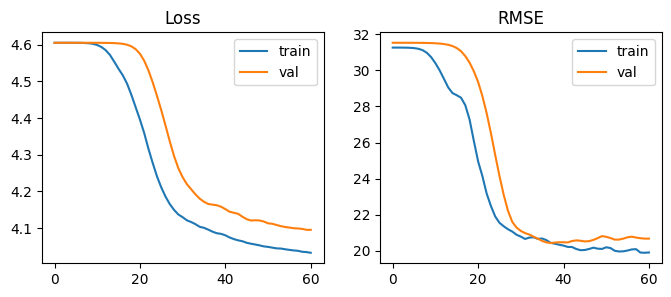

In [242]:
train_losses, val_losses, train_rmses, val_rmses, model = train_loop(train_ratings.shape[0], 
                                                              train_ratings.shape[1],
                                                              train_adj_music,
                                                              test_adj_music,
                                                              num_epochs=61)
plot(train_losses, val_losses, train_rmses, val_rmses)

In [243]:
print(f'Best val RMSE: {min(val_rmses)}')

Best val RMSE: 20.439830780029297


The same dataset and the same train-test split as in the paper were used here.
Paper's RMSE: 20.5.

However, I didn't obtain access to the entire YahooMusic dataset with indices mapping to song descriptions.